In [1]:
import nideconv
import glob
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

reg = re.compile('.*/(?P<ds>ds-[0-9]+)/sub-(?P<subject>[0-9]+)_run-(?P<run>[0-9]+).csv')
fns = glob.glob('./extracted_signals_func/ds-*/sub-*.csv')

/home/stevenm/.conda/envs/python3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/home/stevenm/.conda/envs/python3/lib/python3.6/importlib/_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/stevenm/.conda/envs/python3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/stevenm/.conda/envs/python3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/home/stevenm/.conda/envs/python3/lib/python3.6/importlib/_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling 

In [2]:
df = []

for fn in fns:
    
    if reg.match(fn):
    
        d = pd.read_csv(fn, index_col=0)#.to_frame('signal')
        meta = reg.match(fn).groupdict()

        for key in meta:
            d[key] = meta[key]

        d.index.name = 't'
        d.reset_index()
        d['subject'] = d.apply(lambda row: '{subject}'.format(**row.to_dict()), 1)
        
        
#        d['mask'] = d.apply(lambda row: '{mask}-{subroi}'.format(**row.to_dict()), 1)
#         d.drop('ds', 1, inplace=True)
        df.append(d)
    
df = pd.concat(df).reset_index()
df['subject'] = df['subject'].astype(int)
df.loc[df['ds']=='ds-02', 'subject'] += df.loc[df['ds']=='ds-01', 'subject'].max()
df['run'] = df['run'].astype(int)
del df['ds']
df = df.set_index(['subject', 'run', 't']).sort_values(['subject', 'run', 't'])
df.head()

ACC        cc  cerebellar    insula  midbrain  parietal  \
subject run t                                                                  
1       1   0  -0.131934 -0.370015    0.285113  0.205679  0.115438 -0.190867   
            3  -0.486127 -0.316058   -0.008853  0.023859 -0.161950 -0.294058   
            6  -0.517617 -0.371731    0.085280 -0.002072 -0.082317 -0.340620   
            9  -0.435926 -0.164898    0.239405  0.073899  0.172281 -0.312837   
            12 -0.310153  0.043689    0.228538  0.191192  0.315341 -0.269542   

                    rifg  
subject run t             
1       1   0  -0.370903  
            3  -0.363414  
            6  -0.404459  
            9  -0.303271  
            12 -0.052506

In [3]:
reg = re.compile('.*/(?P<ds>ds-[0-9]+)/.*/sub-(?P<subject>[0-9]+)_task-randomdotmotion_run-(?P<run>[0-9]+)_events.tsv')

In [4]:
## get events
behavior = pd.read_pickle('./derivatives/behavior.pkl')
behavior['sub'] = behavior['subject']
behavior.loc[behavior['ds']=='ds-02', 'sub'] = behavior.loc[behavior['ds']=='ds-02', 'sub'].astype(int) + behavior.loc[behavior['ds']=='ds-01', 'sub'].astype(int).max()
behavior['sub'] = behavior['sub'].astype(int)
behavior['onset_response'] = behavior['onset_stim'] + behavior['rt']/1000
behavior = behavior.loc[behavior.response.isin([1,2])]  # remove errors

events_cue = behavior[['sub', 'block', 'cue', 'onset_cue']]
events_cue['event_type'] = events_cue['cue'].apply(lambda x: 'cue_' + x)
events_cue = events_cue.rename(columns={'block': 'run', 'onset_cue': 'onset'})

events_stim = behavior[['sub', 'block', 'difficulty', 'onset_stim']]
events_stim = events_stim.rename(columns={'block': 'run', 'onset_stim': 'onset', 'difficulty': 'event_type'})

events_responses = behavior[['sub', 'block', 'response', 'onset_response']]
events_responses['event_type'] = events_responses['response'].replace({1: 'response_left', 2: 'response_right', -1: 'error'})
events_responses = events_responses.rename(columns={'block': 'run', 'onset_response': 'onset'})

events = pd.concat((events_cue, events_stim, events_responses))
events = events.sort_values(by=['sub', 'run', 'onset'])
events = events.rename(columns={'sub': 'subject'})

events = events.set_index(['subject', 'run'])[['onset', 'event_type']]#.rename(columns={'event_type': 'trial_type'})
events['duration'] = 0.001
events.head()

# ## correct onsets due to STC
events['onset'] -= 1.5
events.head()

/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:20: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



onset     event_type  duration
subject run                                 
1       1     6.000       cue_left     0.001
        1     8.750           easy     0.001
        1     9.821  response_left     0.001
        1    15.000       cue_left     0.001
        1    17.750           hard     0.001

In [5]:
## get confounds
all_csvs = glob.glob('./derivatives/ds-*/fmriprep/sub*/func/sub-*_task-randomdotmotion_run-*_desc-confounds_regressors.tsv')

reg = re.compile('.*ds-(?P<ds>\d+)/fmriprep/sub-.*/func/sub-(?P<sub>\d+)_.*_run-(?P<run>\d+)_.*')
reg.match(all_csvs[1]).groupdict()


confounds_df = []

# loop over .csv-files, adding signal row-by-row
for fn in all_csvs:
    d = reg.match(fn).groupdict()
    tmp = pd.read_csv(fn, sep='\t')
    tmp['sub'] = d['sub']
    tmp['run'] = d['run']
    tmp['ds'] = d['ds']
    confounds_df.append(tmp)

confounds_df = pd.concat(confounds_df, axis=0)
confounds_df['ds'] = confounds_df['ds'].astype(int)
confounds_df['run'] = confounds_df['run'].astype(int)
confounds_df['subject'] = confounds_df['sub'].astype(int)

# adjust ds2 subject idx to ensure non-overlapping subject idx
max_sub_ds1 = confounds_df.loc[confounds_df.ds==1,'subject'].max()
confounds_df.loc[confounds_df.ds==2,'subject'] = confounds_df.loc[confounds_df.ds==2,'subject']+max_sub_ds1
confounds_df = confounds_df.sort_values(['ds', 'subject', 'run']).set_index(['ds', 'subject', 'run'])

# Include confounds: 5 ACompCor regressors, cosines for drift, DVARS, rotation & translation params
confounds_deconv = confounds_df.reset_index(level=0, drop=True)
include_confounds = ['a_comp_cor_0' + str(x) for x in range(5)] + ['cosine' + str(x).zfill(2) for x in range(17)]
include_confounds = include_confounds + ['dvars', 'framewise_displacement']
include_confounds = include_confounds + ['rot_' + a for a in ['x', 'y', 'z']]
include_confounds = include_confounds + ['trans_' + a for a in ['x', 'y', 'z']]
confounds_deconv = confounds_deconv[include_confounds]
confounds_deconv.head()

<>:4: DeprecationWarning: invalid escape sequence \d
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:19: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



a_comp_cor_00  a_comp_cor_01  a_comp_cor_02  a_comp_cor_03  \
subject run                                                               
1       1        -0.044264       0.059630      -0.048303       0.070233   
        1        -0.159348       0.053665       0.088146      -0.008486   
        1        -0.152059       0.014026       0.023119      -0.067522   
        1        -0.083787      -0.014693       0.005224      -0.044889   
        1        -0.014454      -0.024021      -0.049482      -0.046033   

             a_comp_cor_04  cosine00  cosine01  cosine02  cosine03  cosine04  \
subject run                                                                    
1       1        -0.244679  0.071888  0.071886  0.071883  0.071879  0.071874   
        1        -0.184745  0.071883  0.071867  0.071841  0.071803  0.071755   
        1        -0.101028  0.071874  0.071829  0.071755  0.071652  0.071519   
        1        -0.002374  0.071860  0.071772  0.071628  0.071425  0.071164   
        1         0.044069  0.071841  0.071697  0.071457  0.071122  0.070693   

             ...  cosine15  cosine16      dvars  framewise_displacement  \
subject run  ...                                                          
1       1    ...  0.071737  0.071717        NaN                     NaN   
        1    ...  0.070528  0.070354  29.408150                0.106529   
        1    ...  0.068132  0.067652  21.839451                0.055383   
        1    ...  0.064587  0.063665  20.462967                0.040175   
        1    ...  0.059955  0.058466  20.429110                0.054571   

                rot_x     rot_y     rot_z   trans_x   trans_y   trans_z  
subject run                                                              
1       1    0.001524  0.000356 -0.000161 -0.082265 -0.115355  0.062333  
        1    0.000932  0.000164  0.000000 -0.070083 -0.092359  0.086446  
        1    0.000673  0.000346 -0.000137 -0.065494 -0.095517  0.105258  
        1    0.000511  0.000322 -0.000230 -0.059378 -0.081704  0.098941  
        1    0.000099  0.000239 -0.000194 -0.051345 -0.065291  0.095407  

[5 rows x 30 columns]

## Plot timeseries

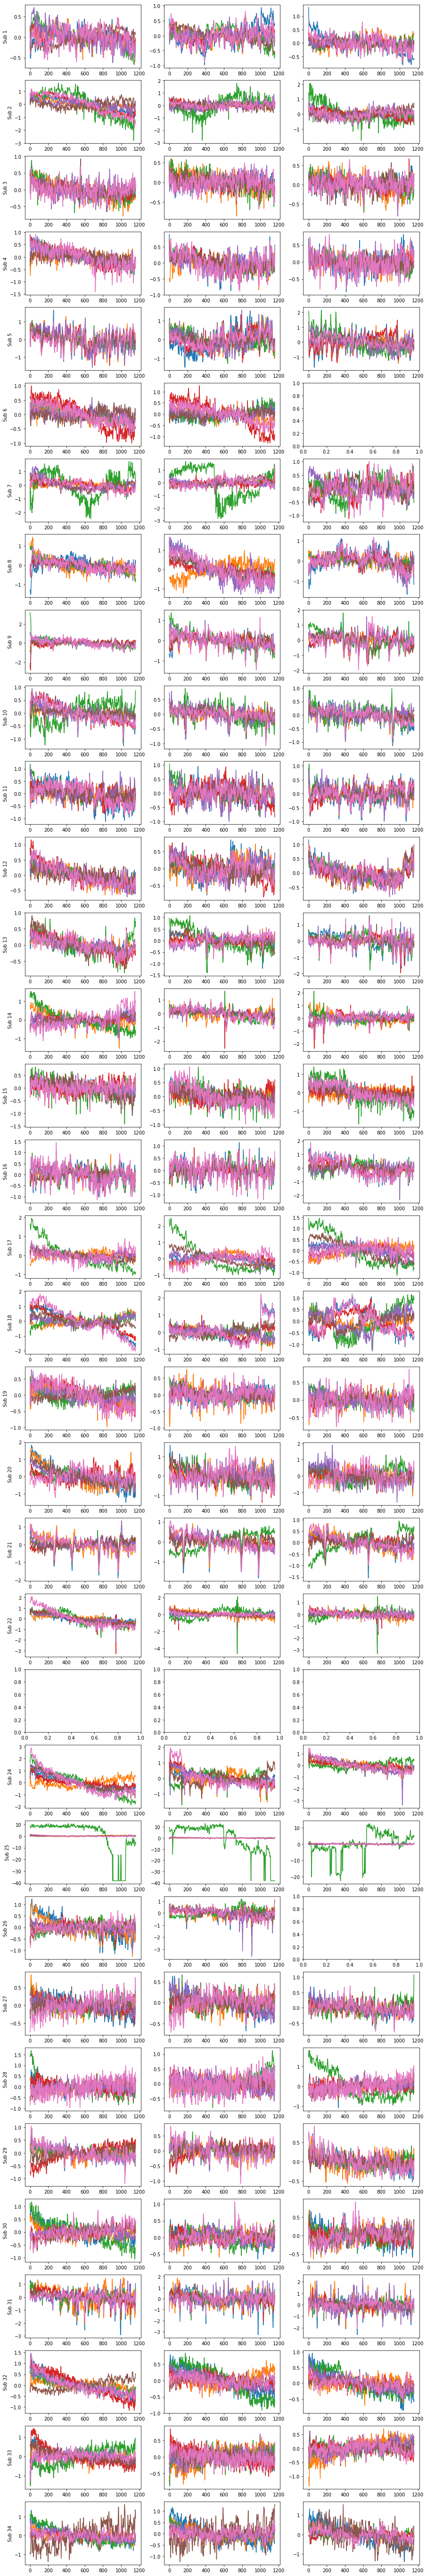

In [6]:
f, ax = plt.subplots(34, 3)
for sub in df.reset_index()['subject'].unique():
    for run in df.loc[sub].reset_index()['run'].unique():
        ax[sub-1,run-1].plot(df.loc[sub, run])
    ax[sub-1,0].set_ylabel('Sub {}'.format(sub))
    
f.set_size_inches(15, 100)

## Deconvolve overall

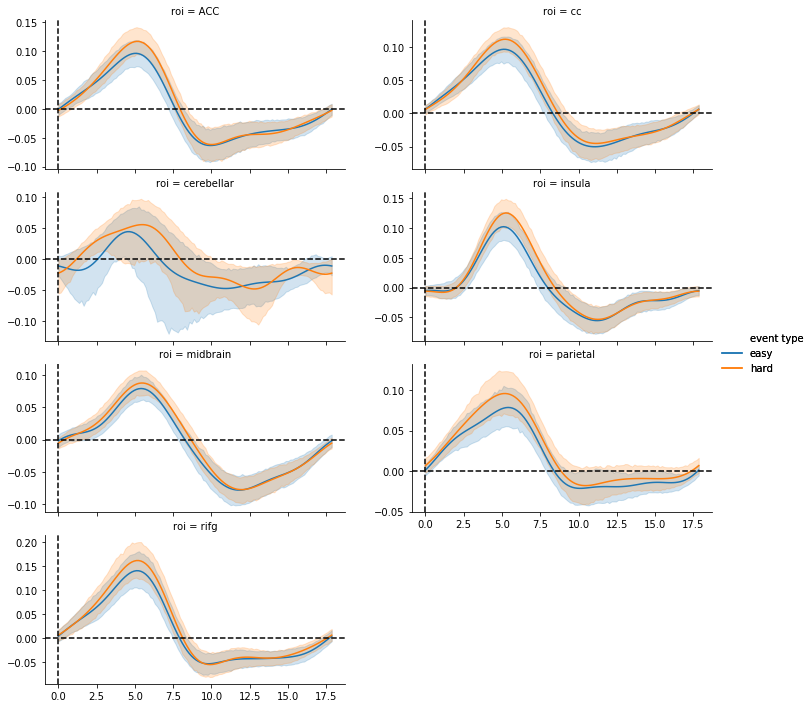

In [8]:
events_ = events.copy()
#events_.loc[events_['event_type'].isin(['cue_left', 'cue_right', 'cue_neutral']), 'event_type'] = 'cue'
#events_.loc[events_['event_type'].isin(['easy', 'hard']), 'event_type'] = 'stim'
events_ = events_[events_['event_type'].isin(['easy', 'hard'])]
del events_['duration']

gf = nideconv.GroupResponseFitter(df, events_, 1/3., confounds=confounds_deconv.fillna(0))
#gf.add_event('cue', interval=[0, 18], basis_set='fourier', n_regressors=9)
#gf.add_event('stim', interval=[0, 18], basis_set='fourier', n_regressors=9)
gf.add_event('easy', interval=[0, 18], basis_set='fourier', n_regressors=9)
gf.add_event('hard', interval=[0, 18], basis_set='fourier', n_regressors=9)

gf.fit()
gf.plot_groupwise_timecourses(event_types=['easy', 'hard'],
                              ci=95, plots='covariate', col='roi', col_wrap=2)

## Leipzig

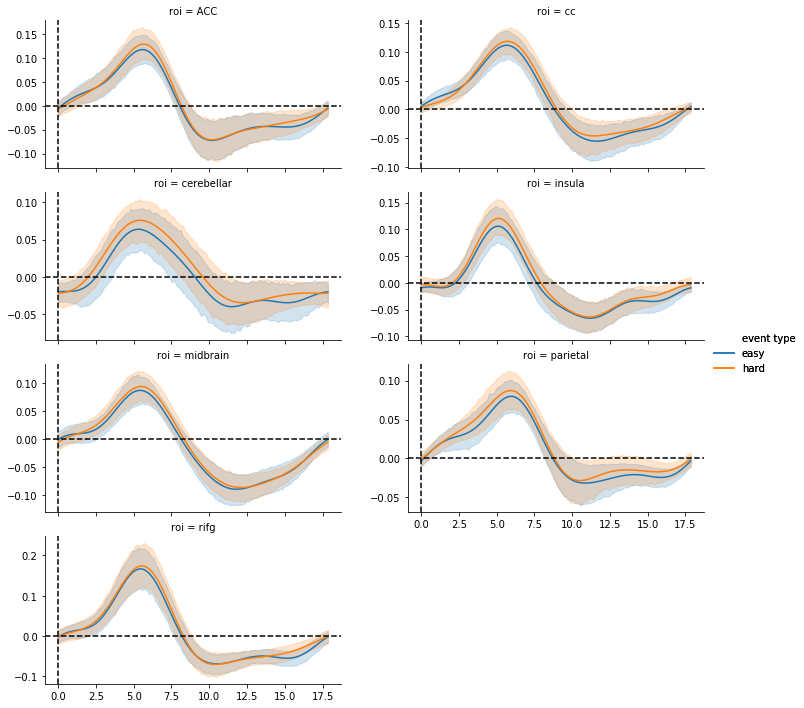

In [10]:
events_ = events.copy().loc[:19]
events_ = events_[events_['event_type'].isin(['easy', 'hard'])]
del events_['duration']
df_ = df.loc[:19]
confounds_ = confounds_deconv.copy().loc[:19]

gfL2 = nideconv.GroupResponseFitter(df_, events_, 1/3., confounds=confounds_.reset_index(), 
                                  oversample_design_matrix=20, concatenate_runs=True)
gfL2.add_event('easy', interval=[0, 18], basis_set='fourier', n_regressors=9)
gfL2.add_event('hard', interval=[0, 18], basis_set='fourier', n_regressors=9)

gfL2.fit()
gfL2.plot_groupwise_timecourses(event_types=['easy', 'hard'], #, 'stim', 'cue'],
                                ci=95, plots='covariate', col='roi', col_wrap=2)

In [16]:
ACC = gfL2._get_response_fitters().apply(lambda x: x.get_time_to_peak()['ACC'].reset_index(level=[1,2], drop=True))
cc = gfL2._get_response_fitters().apply(lambda x: x.get_time_to_peak()['cc'].reset_index(level=[1,2], drop=True))
cerebellar = gfL2._get_response_fitters().apply(lambda x: x.get_time_to_peak()['cerebellar'].reset_index(level=[1,2], drop=True))
insula = gfL2._get_response_fitters().apply(lambda x: x.get_time_to_peak()['insula'].reset_index(level=[1,2], drop=True))
midbrain = gfL2._get_response_fitters().apply(lambda x: x.get_time_to_peak()['midbrain'].reset_index(level=[1,2], drop=True))
parietal = gfL2._get_response_fitters().apply(lambda x: x.get_time_to_peak()['parietal'].reset_index(level=[1,2], drop=True))
rifg = gfL2._get_response_fitters().apply(lambda x: x.get_time_to_peak()['rifg'].reset_index(level=[1,2], drop=True))

L2_peaktimes = pd.concat([ACC['easy'], cc['easy'], cerebellar['easy'], insula['easy'], midbrain['easy'], parietal['easy'], rifg['easy']], axis=1)
L2_peaktimes.columns = ['ACC', 'cc', 'cerebellar', 'insula', 'midbrain', 'parietal', 'rifg']
display(L2_peaktimes)
display(L2_peaktimes.mean(0))

ACC     cc  cerebellar  insula  midbrain  parietal  rifg
subject                                                           
1        5.25   5.40        4.65    4.80      5.40      6.60  5.55
2        6.60   5.85        6.00    5.25      6.45      6.45  3.75
3        6.00   6.15        5.40    5.55      5.55      5.85  5.85
4        5.40   5.40        4.20    5.25      4.95      5.10  5.70
5        5.85   5.40        7.20    1.65      5.40      5.55  5.10
6        5.70   6.15        7.65    5.40      5.25      6.45  5.70
7        7.35   6.90        8.55    6.15      7.35      8.10  7.50
8        5.10   5.55        4.65    4.95      5.25      5.10  4.95
9        5.70   7.35        5.10    5.55      5.40      6.90  5.55
10       3.90   4.80        7.20    3.75      5.55      5.85  4.05
11       5.70   5.10        4.80    5.10      5.55      5.85  5.10
12       5.85   6.00        5.55    5.55      5.55      6.00  5.55
13       5.70   5.70        6.00    5.25      1.80      6.30  5.40
14       6.00   6.75       12.60    5.55      4.95      5.85  5.25
15       4.95   5.40        4.95    4.50      5.10      5.40  5.55
16       5.40  11.25        3.60    4.50      4.95      5.85  5.10
17       6.15   5.55        5.25    5.40      5.40      6.00  5.85
18       4.95   5.70        7.05    5.10      6.45      5.40  5.55
19       5.40   6.30        4.35    4.95      5.40      8.85  5.55

ACC           5.628947
cc            6.142105
cerebellar    6.039474
insula        4.957895
midbrain      5.352632
parietal      6.181579
rifg          5.400000
dtype: float64

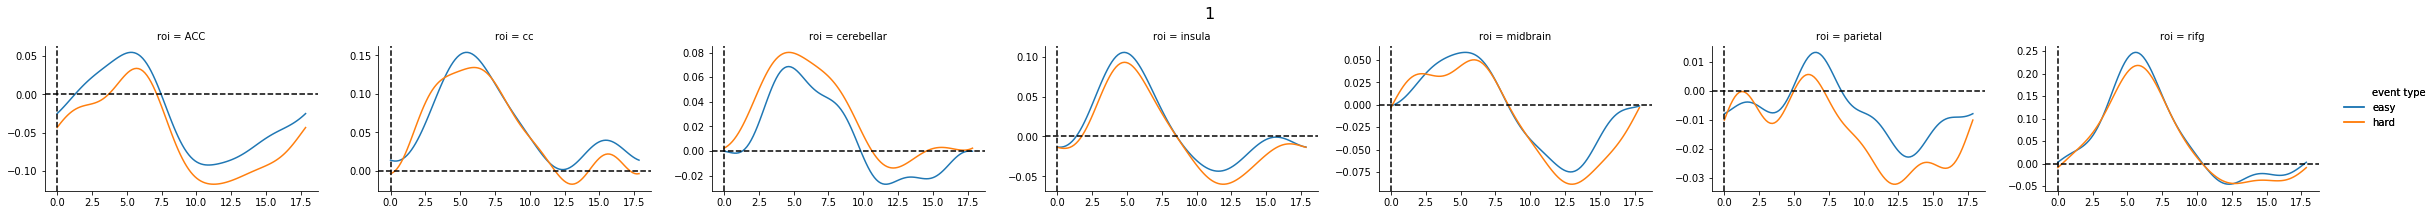

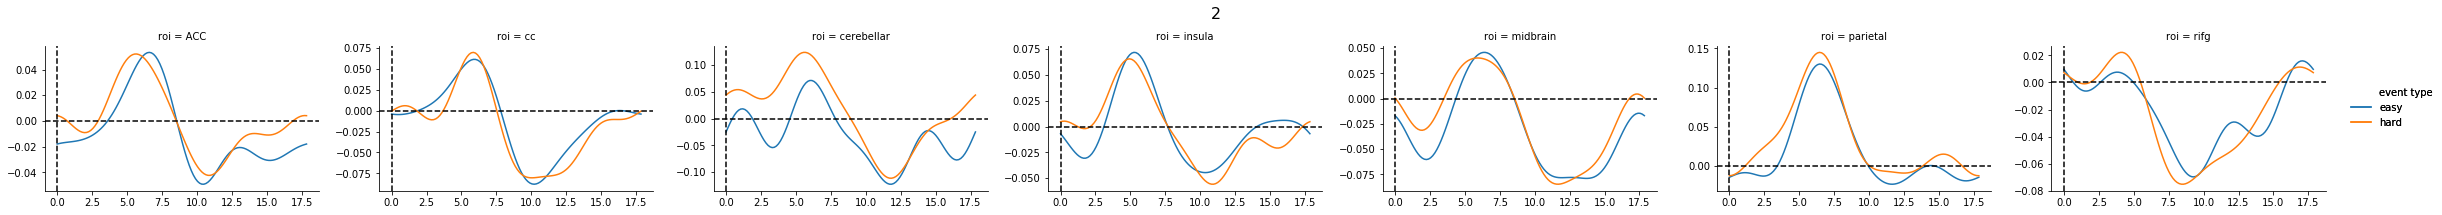

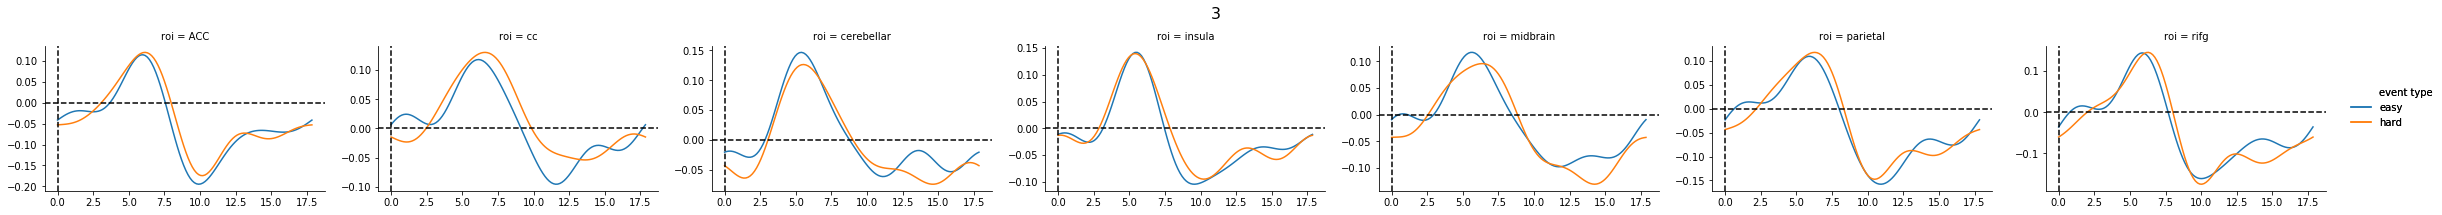

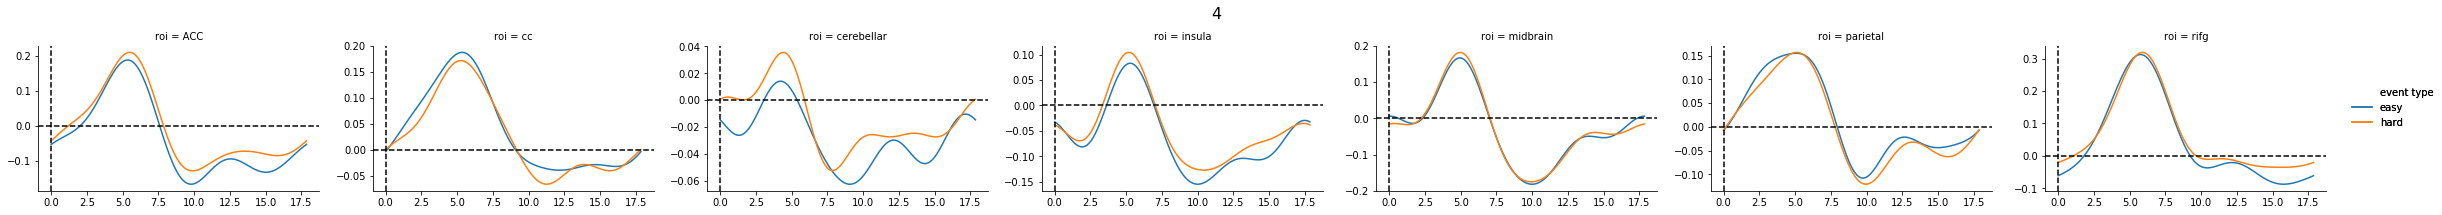

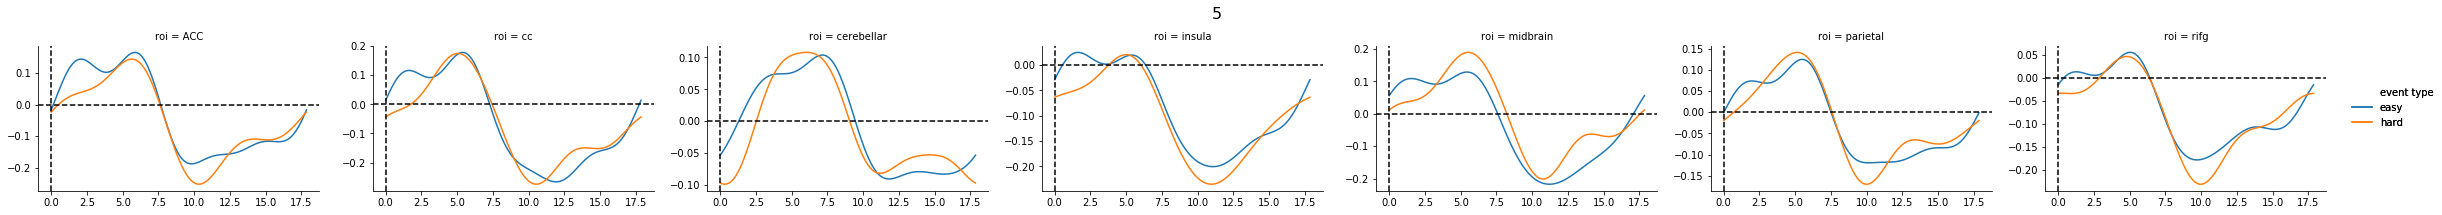

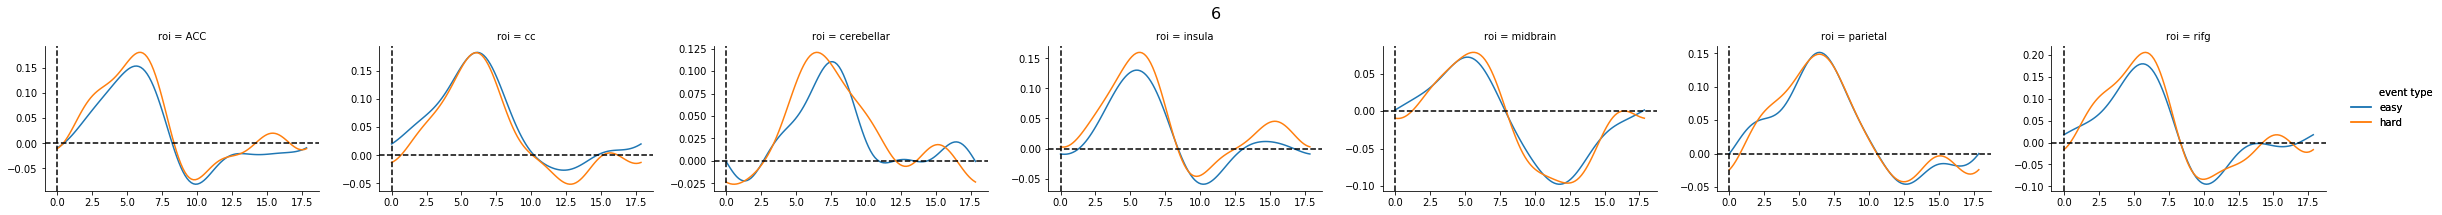

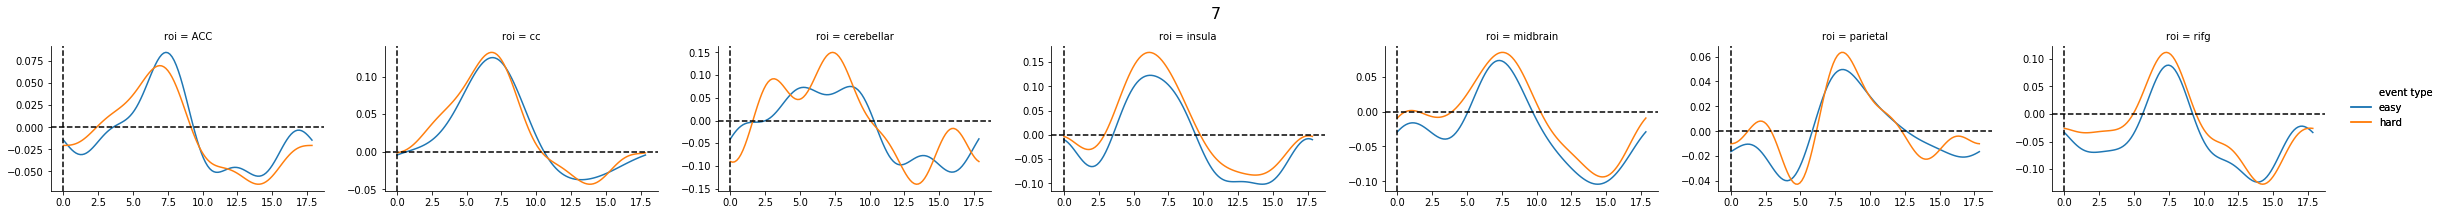

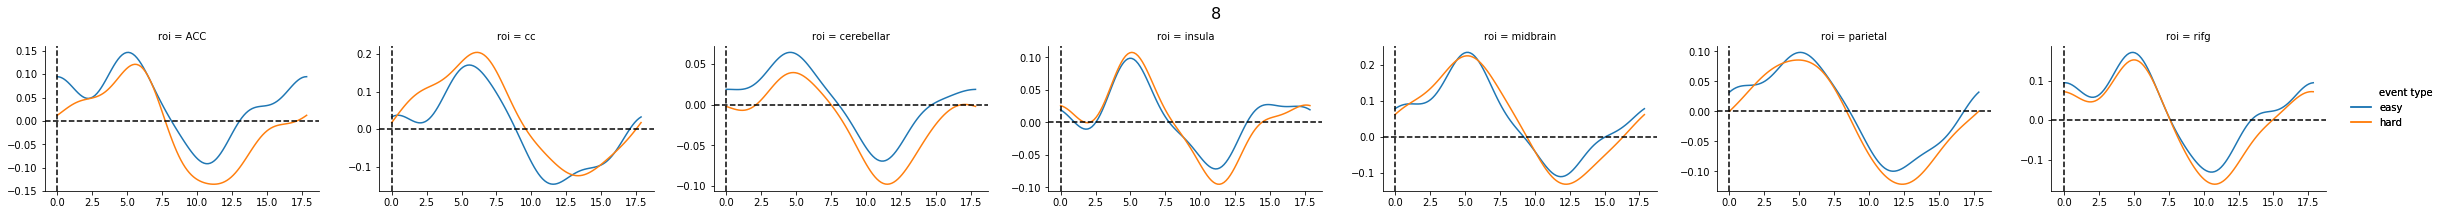

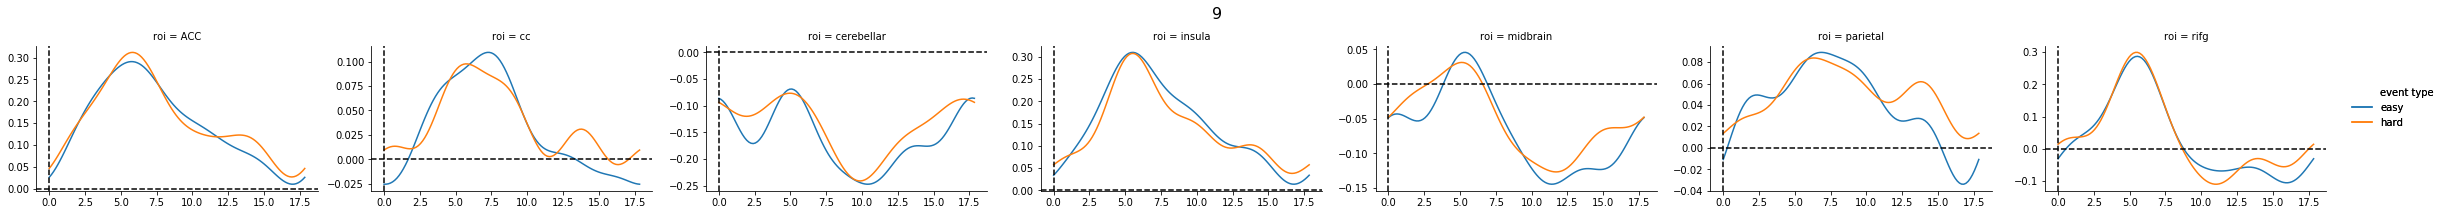

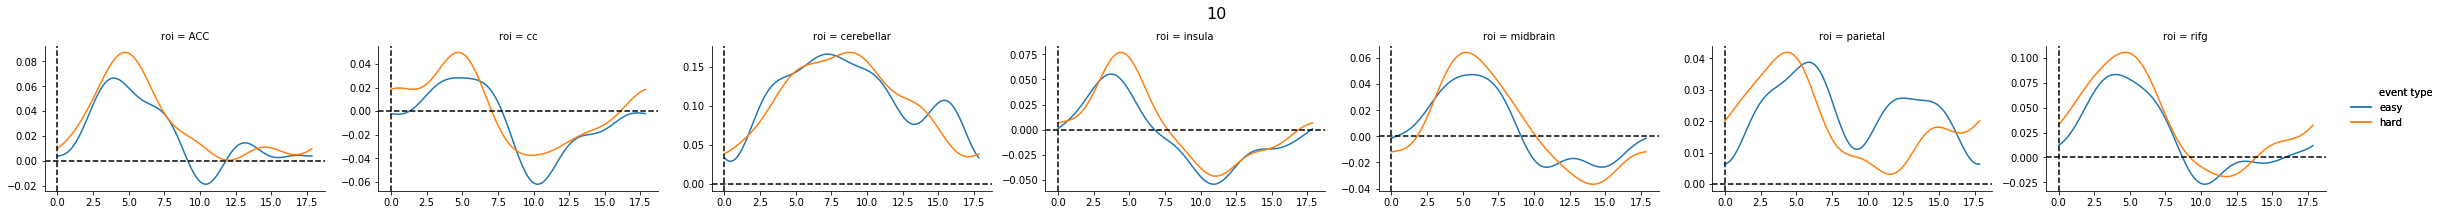

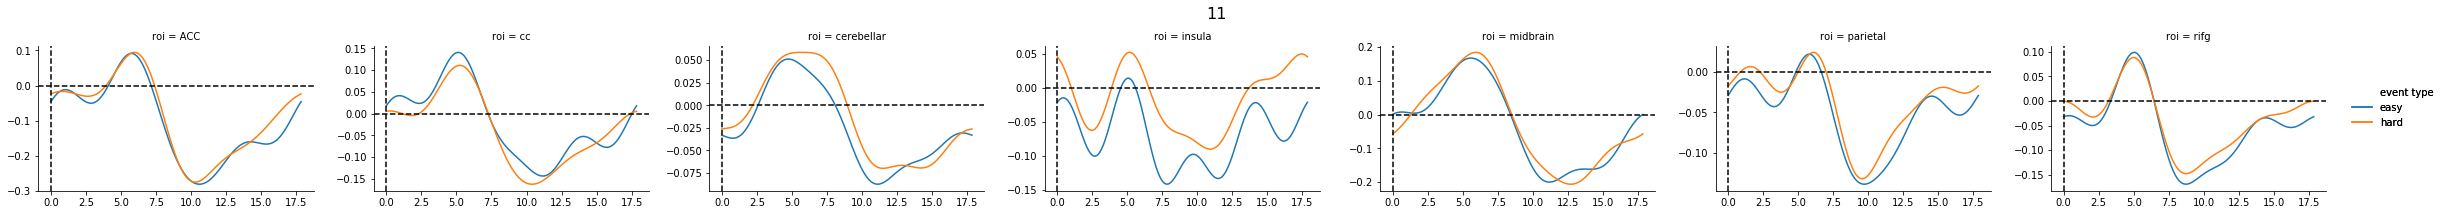

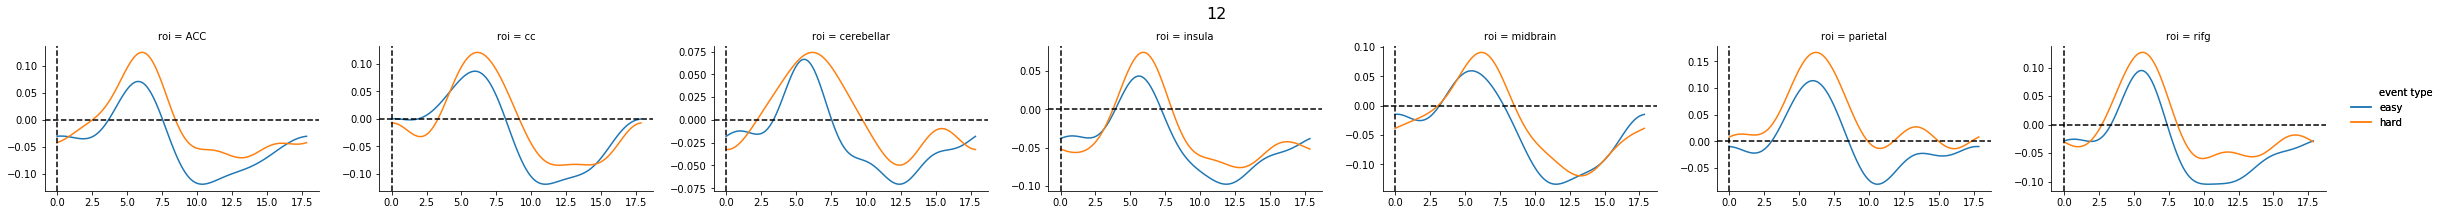

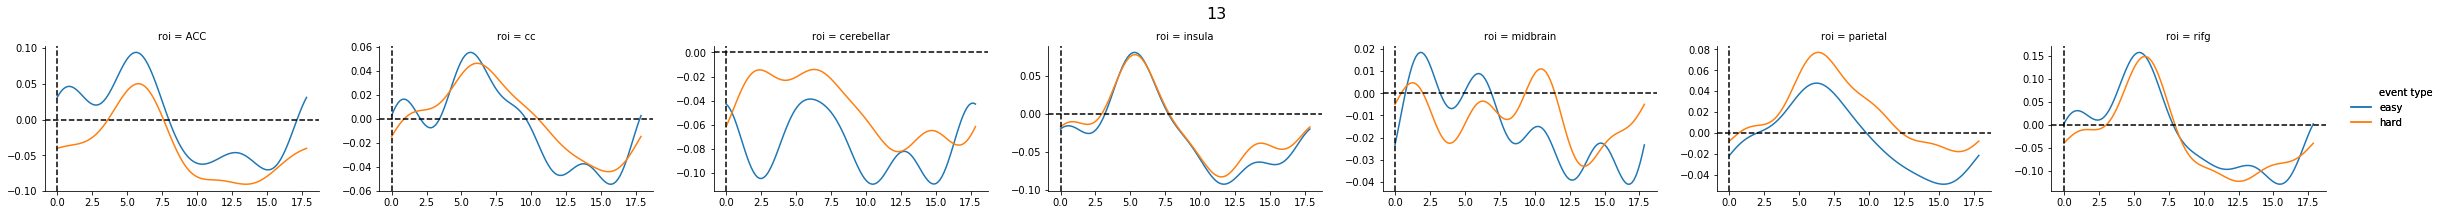

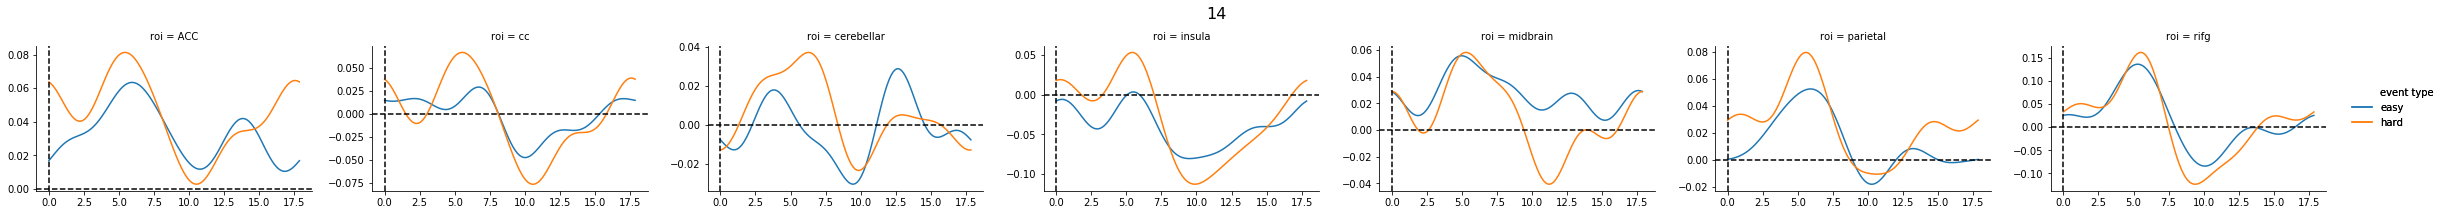

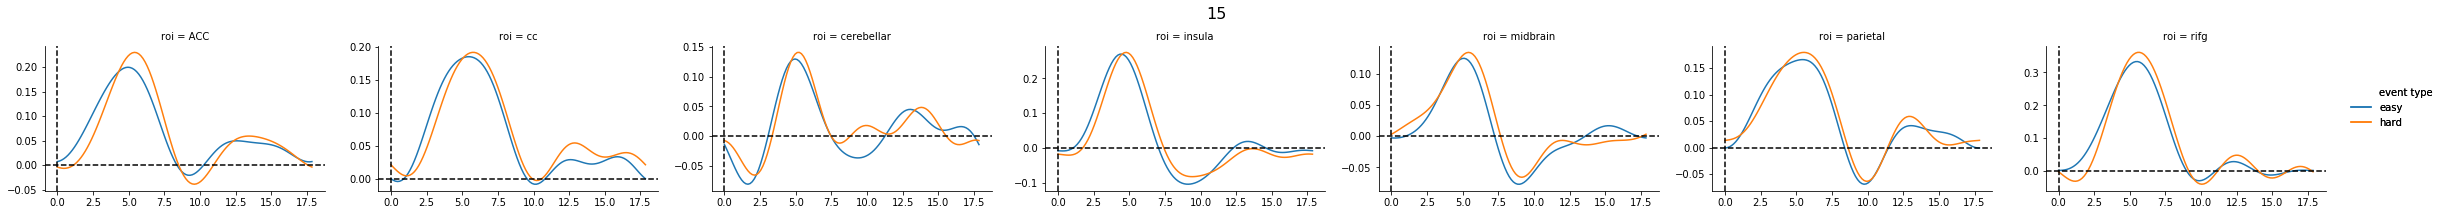

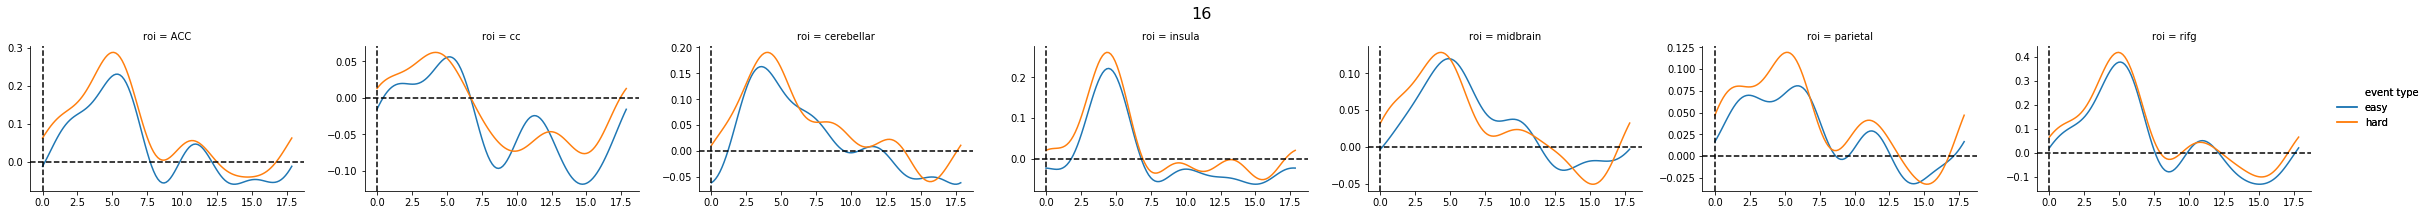

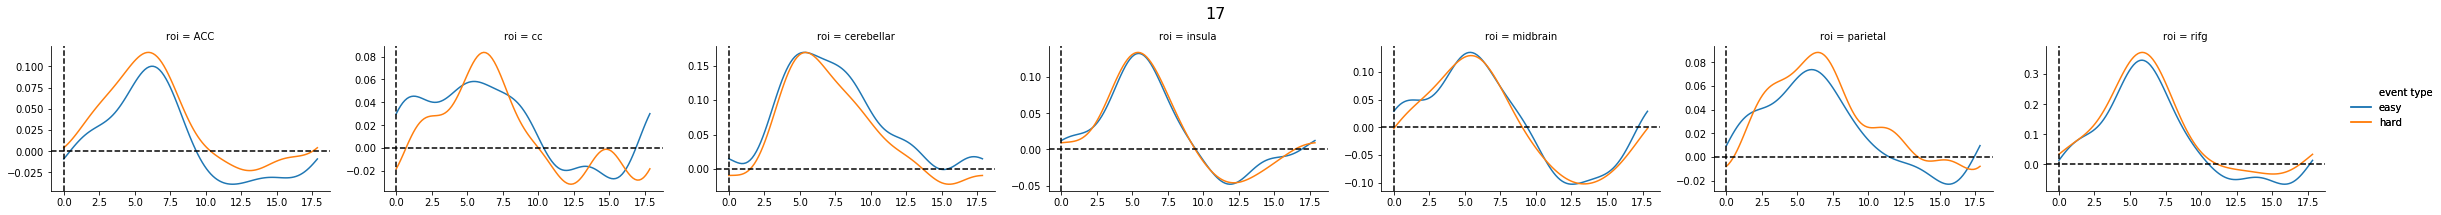

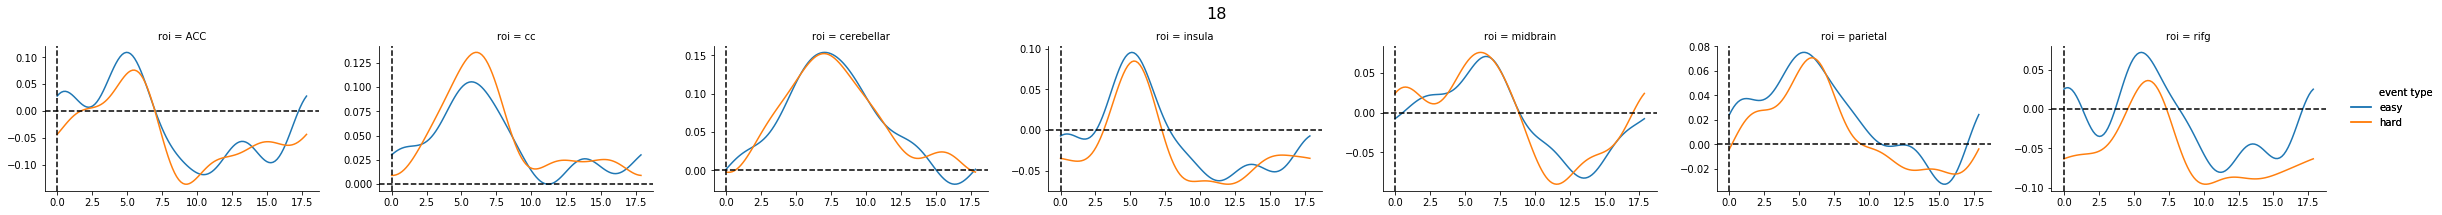

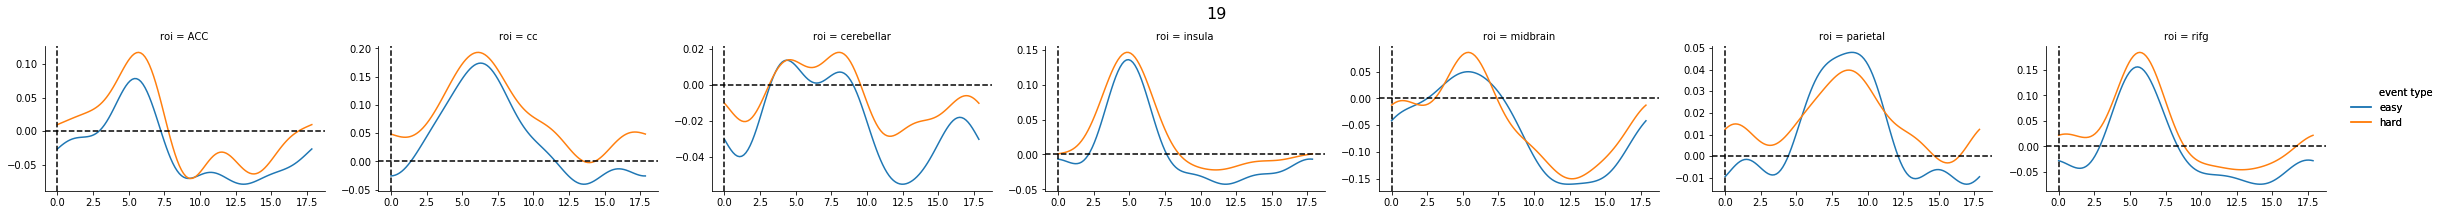

In [13]:
gfL2.plot_subject_timecourses(event_types=['easy', 'hard'], 
                              row=None, col='roi', plots='subject', col_wrap=None)

## Amsterdam

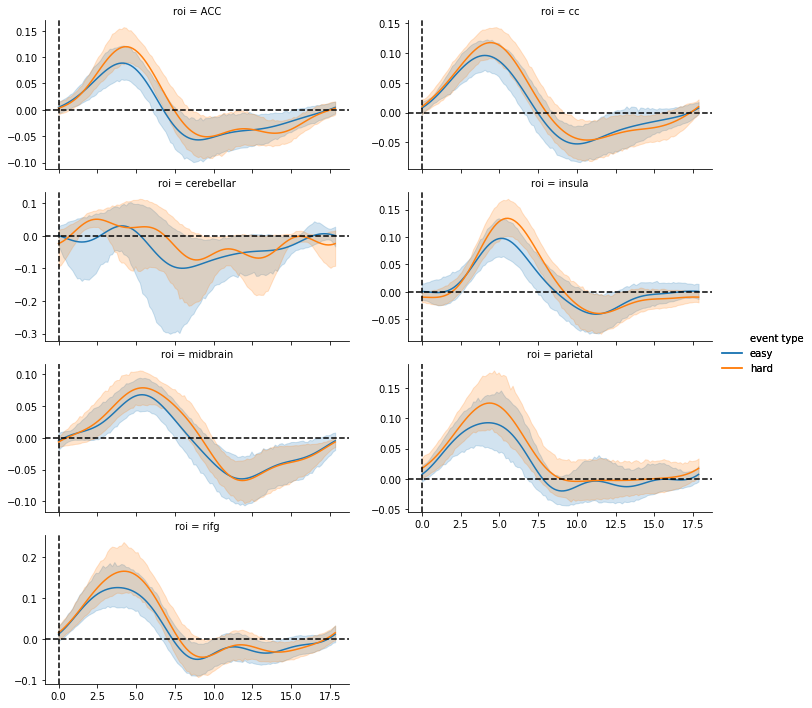

In [18]:
events_ = events.copy().loc[20:]
events_ = events_[events_['event_type'].isin(['easy', 'hard'])]
del events_['duration']
df_ = df.loc[20:]
confounds_ = confounds_deconv.copy().loc[20:] #.reset_index()

gfA2 = nideconv.GroupResponseFitter(df_, events_, 1/3., confounds=confounds_.fillna(0).reset_index(), 
                                    oversample_design_matrix=20)
gfA2.add_event('easy', interval=[0, 18], basis_set='fourier', n_regressors=9)
gfA2.add_event('hard', interval=[0, 18], basis_set='fourier', n_regressors=9)
# gfA2.add_event('response_left', interval=[0, 18], basis_set='fir')#, n_regressors=9)
# gfA2.add_event('response_right', interval=[0, 18], basis_set='fir')#, n_regressors=9)

gfA2.fit()
gfA2.plot_groupwise_timecourses(event_types=['easy', 'hard'], #, 'stim', 'cue'],
                                ci=95, plots='covariate', col='roi', col_wrap=2)

In [19]:
ACC = gfA2._get_response_fitters().apply(lambda x: x.get_time_to_peak()['ACC'].reset_index(level=[1,2], drop=True))
cc = gfA2._get_response_fitters().apply(lambda x: x.get_time_to_peak()['cc'].reset_index(level=[1,2], drop=True))
cerebellar = gfA2._get_response_fitters().apply(lambda x: x.get_time_to_peak()['cerebellar'].reset_index(level=[1,2], drop=True))
insula = gfA2._get_response_fitters().apply(lambda x: x.get_time_to_peak()['insula'].reset_index(level=[1,2], drop=True))
midbrain = gfA2._get_response_fitters().apply(lambda x: x.get_time_to_peak()['midbrain'].reset_index(level=[1,2], drop=True))
parietal = gfA2._get_response_fitters().apply(lambda x: x.get_time_to_peak()['parietal'].reset_index(level=[1,2], drop=True))
rifg = gfA2._get_response_fitters().apply(lambda x: x.get_time_to_peak()['rifg'].reset_index(level=[1,2], drop=True))

A2_peaktimes = pd.concat([ACC['easy'], cc['easy'], cerebellar['easy'], insula['easy'], midbrain['easy'], parietal['easy'], rifg['easy']], axis=1)
A2_peaktimes.columns = ['ACC', 'cc', 'cerebellar', 'insula', 'midbrain', 'parietal', 'rifg']
display(A2_peaktimes)
display(A2_peaktimes.mean(0))

ACC     cc  cerebellar  insula  midbrain  parietal   rifg
subject                                                             
20        5.70   4.80        5.85    8.40      5.40      5.25   5.25
21        5.55   5.40        4.65    6.00      5.85      5.10   5.25
22        3.45   3.90       13.05    5.70      6.15      2.25   3.00
24        4.35   4.80        6.45    5.70      5.55      5.25   4.65
25        2.55   4.80       16.50    4.35      5.10      3.30   2.85
26       10.05  12.60        5.40   11.85     13.20     11.40  10.65
27        4.05   3.30        4.50    4.65      4.65      4.05   3.75
28        3.90   4.50        4.20    5.25      5.10      3.15   3.15
29        4.95   4.05        4.65    4.95      7.05      3.75   3.75
30        4.20   3.30        3.45    4.20      6.15      4.05   3.45
31        3.00   2.55        4.65    1.95      3.00      2.55   5.55
32        4.50   3.60       14.10    4.95      4.35      4.05   4.65
33        4.05   4.20        5.25    5.10      5.40      4.50   5.10
34        3.75   3.60        5.25    5.10      5.70      5.55   3.45

ACC           4.575000
cc            4.671429
cerebellar    6.996429
insula        5.582143
midbrain      5.903571
parietal      4.585714
rifg          4.607143
dtype: float64

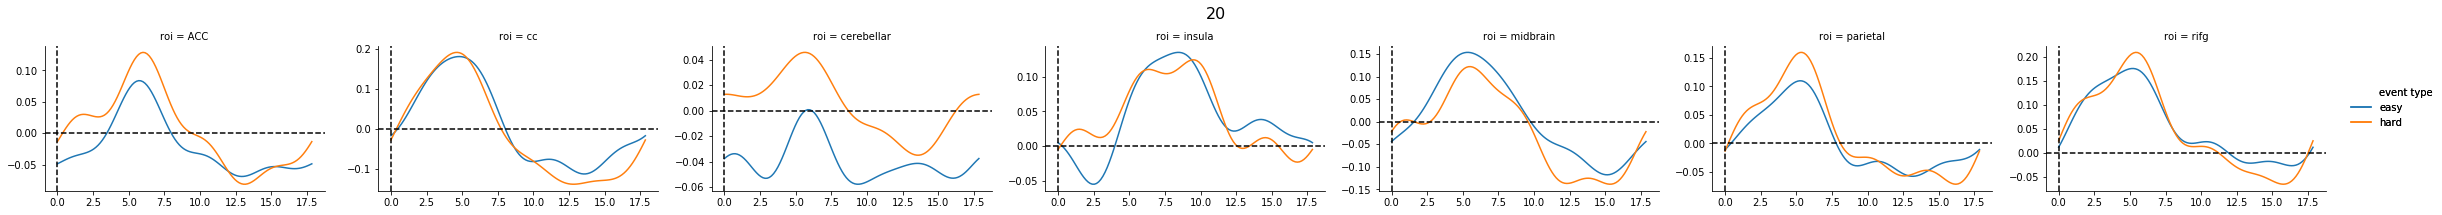

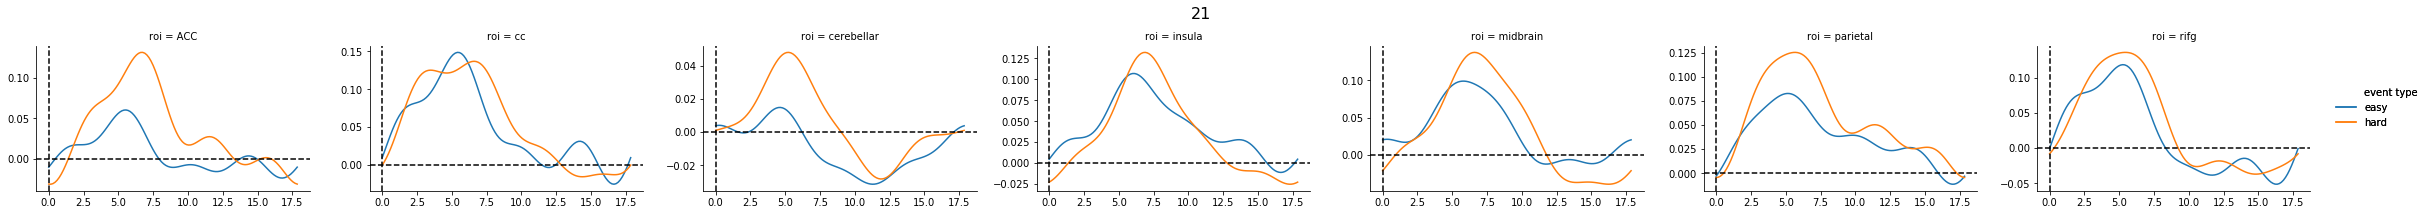

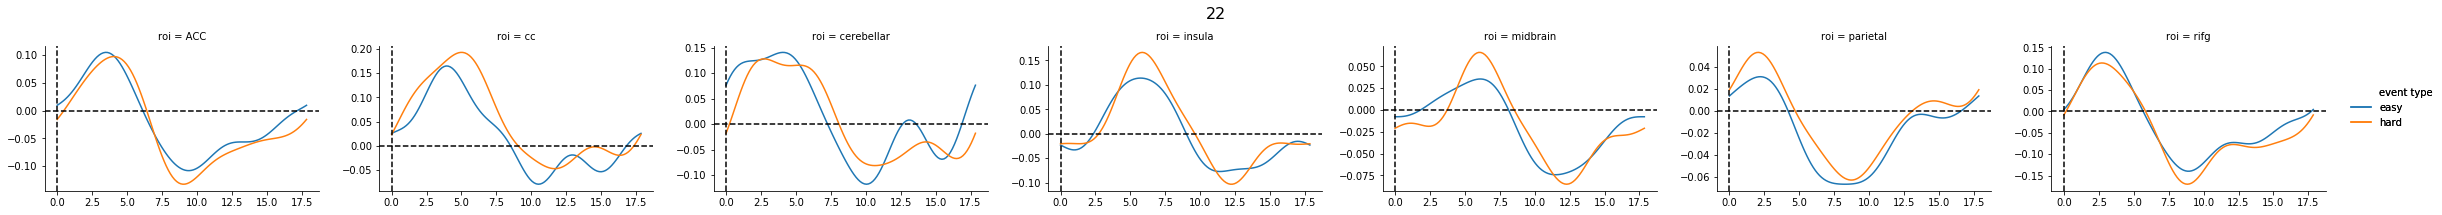

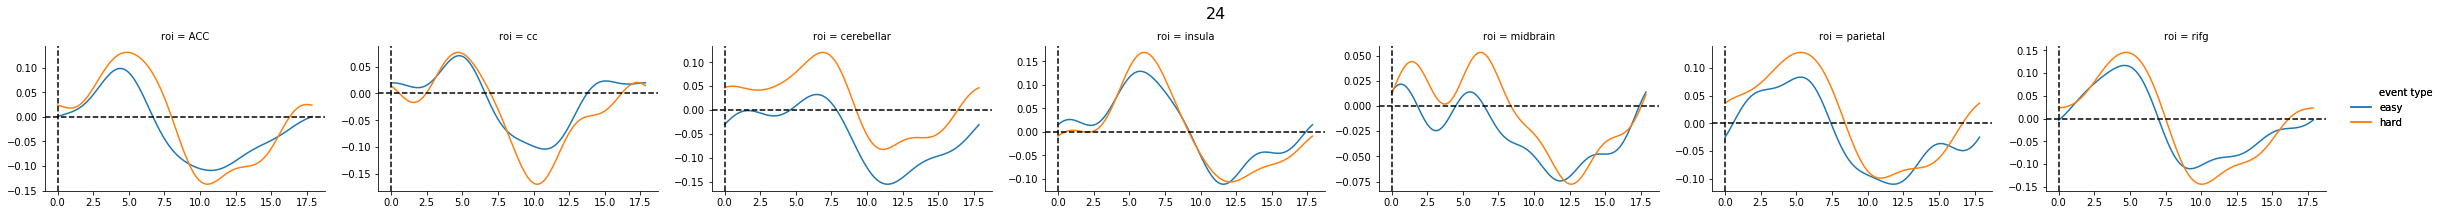

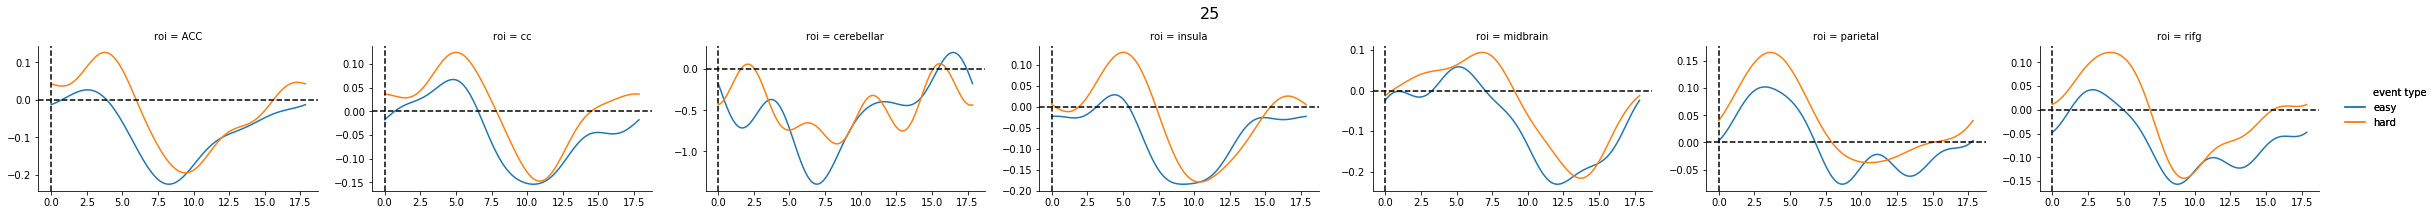

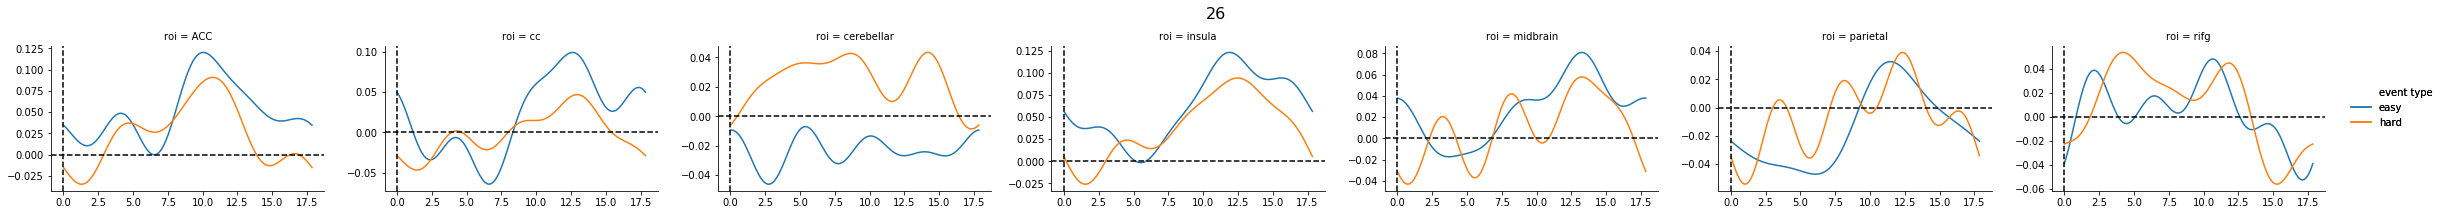

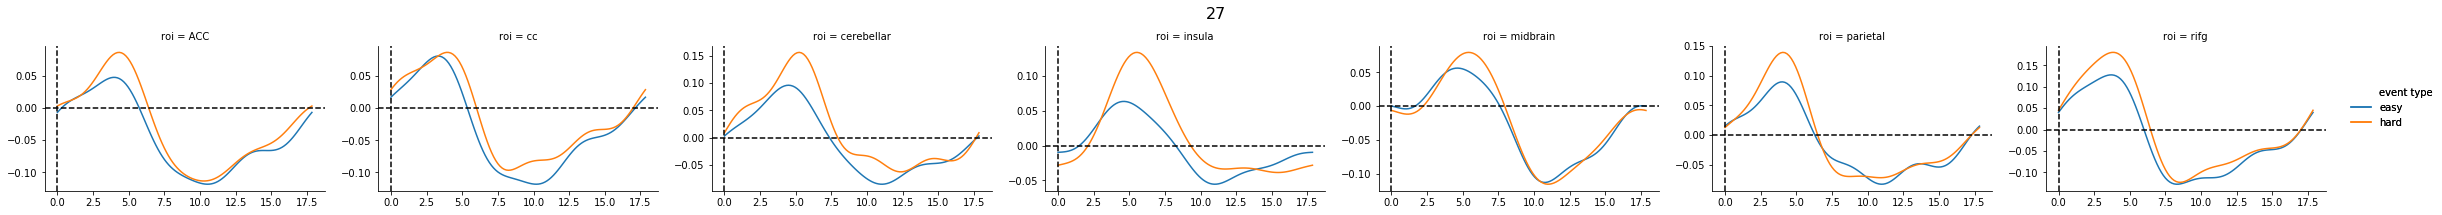

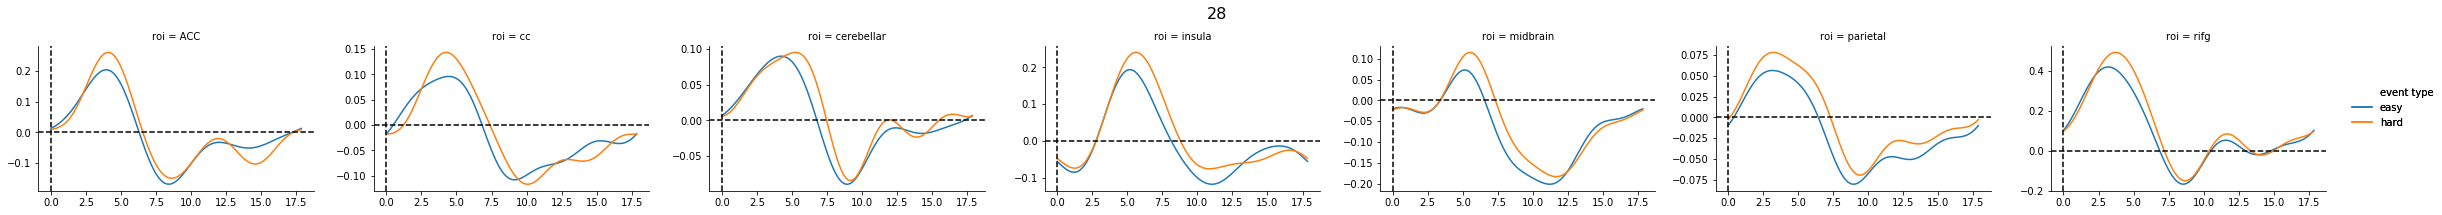

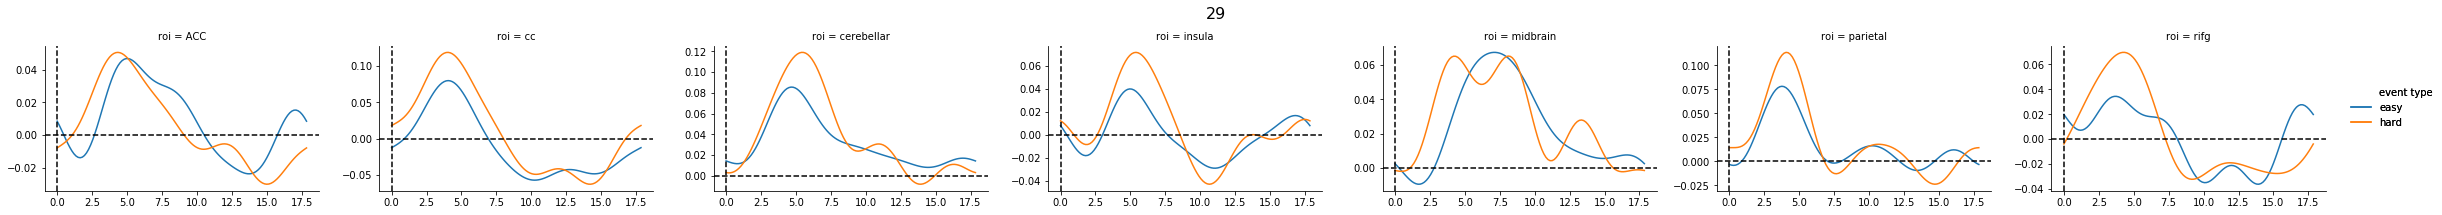

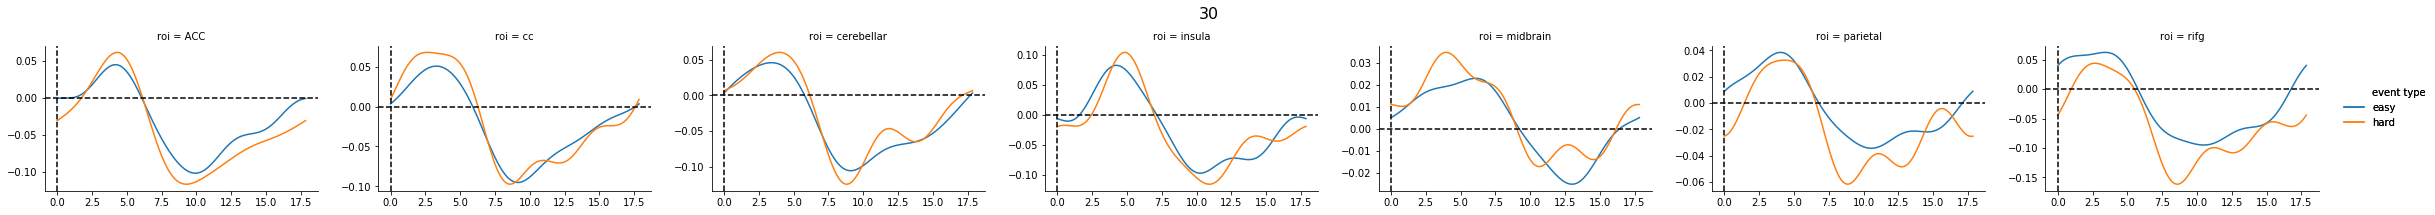

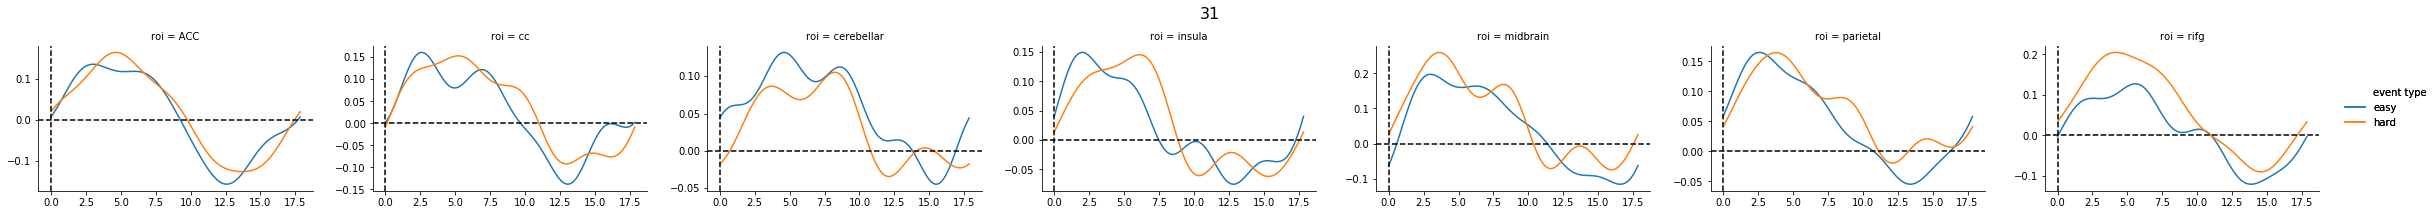

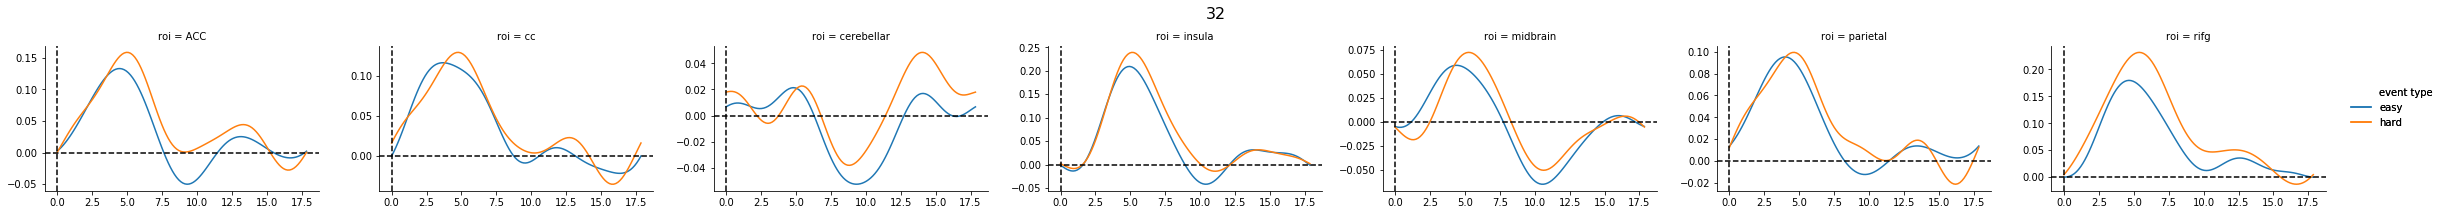

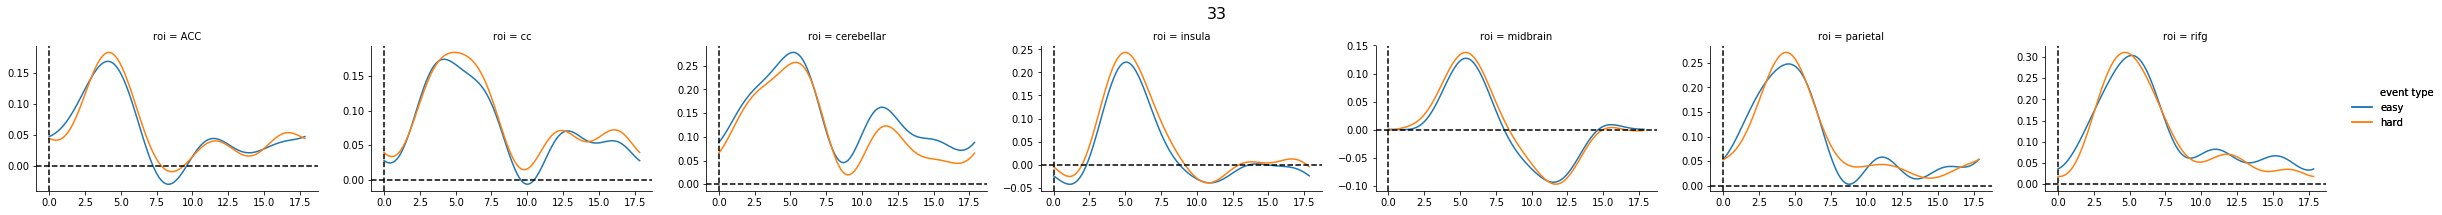

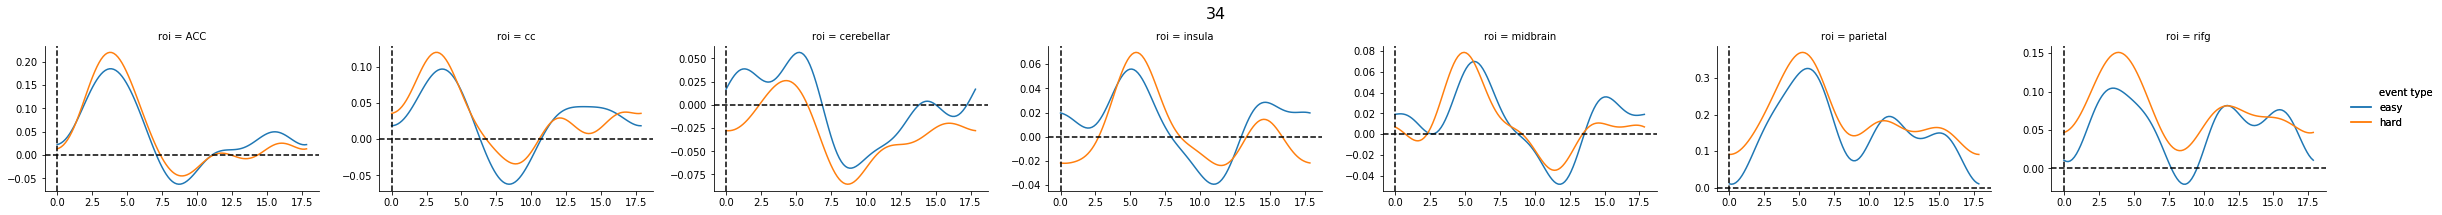

In [20]:
gfA2.plot_subject_timecourses(event_types=['easy', 'hard'], row=None, col='roi', plots='subject', col_wrap=None)

# Compare time to peak

In [34]:
all_peaktimes = pd.concat([L2_peaktimes, A2_peaktimes])
all_peaktimes['ds'] = np.hstack([np.repeat(1, 19), np.repeat(2, 14)])
all_peaktimes_mean = all_peaktimes.groupby('ds').mean()
all_peaktimes_mean

ACC        cc  cerebellar    insula  midbrain  parietal      rifg
ds                                                                        
1   5.628947  6.142105    6.039474  4.957895  5.352632  6.181579  5.400000
2   4.575000  4.671429    6.996429  5.582143  5.903571  4.585714  4.607143

- in ACC, "corpus callosum", partieal, and rIFG, the Leipzig data seems to peak ~0.8 - 1.5s later than the amsterdam data
- In cerebellum, insula, midbrain the differences are in the opposite direction and a bit smaller (0.6-0.9s)

We can add the z-locations of these ROIs to see if this could explain the difference in peak time

In [35]:
all_peaktimes_mean2 = all_peaktimes_mean.T
all_peaktimes_mean2['diff'] = all_peaktimes_mean2[1]-all_peaktimes_mean2[2]
all_peaktimes_mean2['com_z'] = [39, 29, -25, 4, 8, 42, 30]
all_peaktimes_mean2

ds                 1         2      diff  com_z
ACC         5.628947  4.575000  1.053947     39
cc          6.142105  4.671429  1.470677     29
cerebellar  6.039474  6.996429 -0.956955    -25
insula      4.957895  5.582143 -0.624248      4
midbrain    5.352632  5.903571 -0.550940      8
parietal    6.181579  4.585714  1.595865     42
rifg        5.400000  4.607143  0.792857     30

Text(0, 0.5, 'Difference in peak onset')

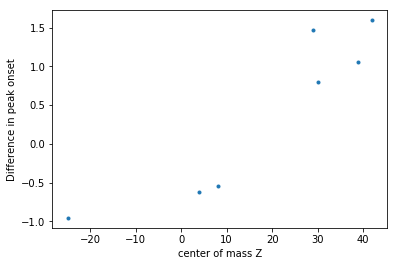

In [39]:
plt.plot(all_peaktimes_mean2['com_z'], all_peaktimes_mean2['diff'], '.')
plt.xlabel('center of mass Z')
plt.ylabel('Difference in peak onset')

#### Despite the low number of ROIs, there seems to be a strong correlation between the z-location and the *difference* in peak timing between datasets.
## In conclusion: one (or both) of the datasets probably still has/have the wrong slice timing correction.